Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = ""
IMMATRICULATION_NUMBER = ""

---

# Exercise 13: Grammar-based Graph Compression

Goals of this exercise: 
- understand and implement the computation of the digrams and their frequencies
- get a better understanding of grammar-based graph compression

**Remark:** This Assignment has to be solved with the help of SQL queries. If you are not familiar with SQL, as e.g. the lecture "Datenbanksysteme" is not part of your study course up to now(e.g. for some of you studying to become a teacher), instead of writing queries, you should describe for **one** line of each table that is given as a result for each task, how this line is computed from the previous results or tables. In this case, of course, the automatic tests will not work


## 0. Setting up the database

The following code imports the data given in the file <code>graph.csv</code> into the database <code>graph.db</code>.

This file contains a table representing the following example graph:

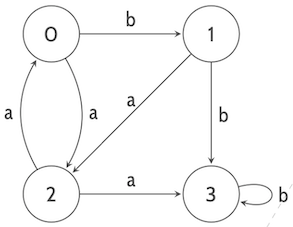

Each line in the table represents edge of the graph and contains the edge label, the start node and the end node of this graph.

| Label| Node0 | Node1 |
|:-----|:------|:------|
| b    | 0     | 1     |
| a    | 0     | 2     |
| a    | 1     | 2     |
| b    | 1     | 3     |
| a    | 2     | 0     |
| a    | 2     | 3     |
| b    | 3     | 3     |


**Hint:** 
If you want to test your implementation for different graphs, you could add a corresponding csv file and rerun the code on your own csv file. 
After having run the next cell, you can use the cell below containing the code <code>graph</code> only to pretty print the content of your csv file and the next cell containing the code <code>enn</code> only to pretty print the content the imported database table ENN.


In [3]:
import pandas as pd
import sqlite3 as sql

df = pd.read_csv('graph.csv')

graph = pd.DataFrame(dict(
    label=df['Label'],
    node0=df['Node0'],
    node1=df['Node1']))

conn = sql.connect('graph.db')
conn.execute("DROP Table IF EXISTS ENN")
conn.commit()
graph.to_sql('ENN', conn,
               if_exists='replace',
               index=False)

enn = pd.read_sql_query("SELECT * FROM ENN", conn)

conn.close()

In [4]:
graph

,label,node0,node1
0,b,0,1
1,a,0,2
2,a,1,2
3,b,1,3
4,a,2,0
5,a,2,3
6,b,3,3


In [5]:
enn

,label,node0,node1
0,b,0,1
1,a,0,2
2,a,1,2
3,b,1,3
4,a,2,0
5,a,2,3
6,b,3,3


## 1. Computing the incidence types of each pair of edge and adjacent edge

Write an SQL query that computes a view named <code>NIE</code> that contains all pairs of an edge label and a node <code>no</code> adjacent to this edge and that contains the incidence type 0 whenever the node <code>no</code> is the start node of the edge and the incidence type 1 otherwise.

The columns of the view <code>NIE</code> are:
| Node | Incidence | Label|
|:-----|:----------|:-----|


If run on the given graph, the view <code>NIE</code> should compute the following data:

| Node | Incidence | Label|
|:-----|:----------|:-----|
|0     |0          | b    |
|0     |0          | a    |
|1     |0          | a    |
|1     |0          | b    |
|2     |0          | a    |
|2     |0          | a    |
|3     |0          | b    |
|1     |1          | b    |
|2     |1          | a    |
|2     |1          | a    |
|3     |1          | b    |
|o     |1          | a    |
|3     |1          | a    |
|3     |1          | b    |

In [12]:
import pandas as pd
import sqlite3 as sql

query = """
CREATE VIEW NIE AS
SELECT node0 as Node, 0 as Incidence, label as Label FROM ENN
UNION ALL
SELECT node1 as Node, 1 as Incidence, label as Label FROM ENN
"""

conn = sql.connect('graph.db')

conn.execute("DROP VIEW IF EXISTS NIE")
conn.commit()
conn.execute(query)
conn.commit()

nie = pd.read_sql_query("SELECT * FROM NIE", conn)

conn.close()

nie

,Node,Incidence,Label
0,0,0,b
1,0,0,a
2,1,0,a
3,1,0,b
4,2,0,a
5,2,0,a
6,3,0,b
7,1,1,b
8,2,1,a
9,2,1,a


In [13]:
from io import StringIO
from pandas.testing import assert_frame_equal

TESTDATA = StringIO("""Node	Incidence	Label
0	0	b
0	0	a
1	0	a
1	0	b
2	0	a
2	0	a
3	0	b
1	1	b
2	1	a
2	1	a
3	1	b
0	1	a
3	1	a
3	1	b
    """)

sol1 = pd.read_csv(TESTDATA, sep="\t")
sol1 = sol1.sort_values(by=['Node','Incidence','Label'])
sol1.reset_index(drop=True, inplace=True)
nie = nie.sort_values(by=['Node','Incidence','Label'])
nie.reset_index(drop=True, inplace=True)
assert_frame_equal(sol1, nie, check_like=True)

## 2. Computing the number of occurrences of Labels and Incidences

Write an SQL query that computes a view named <code>IL_occurrences</code> containing the columns:

| Node | Incidence | Label | Number_Of_Occurrences |
|:-----|:----------|:------|:----------------------|


This view contains for each triple of node, edge incidence and edge label the number of its occurrences.

If run on the given data, the view <code>IL_occurrences</code> should contain the following data:

|Node|	Incidence|	Label|	Number_Of_Occurrences|
|:---|:----------|:----------|:----------|
|0|	0|	a|	1|
|0|	0|	b|	1|
|0|	1|	a|	1|
|1|	0|	a|	1|
|1|	0|	b|	1|
|1|	1|	b|	1|
|2|	0|	a|	2|
|2|	1|	a|	2|
|3|	0|	b|	1|
|3|	1|	a|	1|
|3|	1|	b|	2|


In [15]:
import pandas as pd
import sqlite3 as sql

query = """
CREATE VIEW IL_occurrences AS
SELECT Node, Incidence, Label, COUNT(*) as Number_Of_Occurrences FROM NIE
GROUP BY Node, Incidence, Label
"""

conn = sql.connect('graph.db')

conn.execute("DROP VIEW IF EXISTS IL_occurrences")
conn.commit()
conn.execute(query)
conn.commit()

il_occurrences = pd.read_sql_query("SELECT * FROM IL_occurrences", conn)

conn.close()

il_occurrences

,Node,Incidence,Label,Number_Of_Occurrences
0,0,0,a,1
1,0,0,b,1
2,0,1,a,1
3,1,0,a,1
4,1,0,b,1
5,1,1,b,1
6,2,0,a,2
7,2,1,a,2
8,3,0,b,1
9,3,1,a,1


In [16]:
from io import StringIO
from pandas.testing import assert_frame_equal

TESTDATA = StringIO("""Node	Incidence	Label	Number_Of_Occurrences
0	0	a	1
0	0	b	1
0	1	a	1
1	0	a	1
1	0	b	1
1	1	b	1
2	0	a	2
2	1	a	2
3	0	b	1
3	1	a	1
3	1	b	2
    """)

sol2 = pd.read_csv(TESTDATA, sep="\t")
sol2 = sol2.sort_values(by=['Node','Incidence','Label','Number_Of_Occurrences'])
sol2.reset_index(drop=True, inplace=True)
il_occurrences = il_occurrences.sort_values(by=['Node','Incidence','Label','Number_Of_Occurrences'])
il_occurrences.reset_index(drop=True, inplace=True)
assert_frame_equal(sol2, il_occurrences, check_like=True)

## 3. Computing the number of occurrences of digramms for each node

Write an SQL query computing a view <code>D_occurrences</code>

| Node | Incidence1 | Label1 | Incidence2 | Label2 | Number_of_D_Occurrences |
|:-----|:-----------|:-------|:-----------|:-------|:----------------------------| 

that contains for each 5-tuple of node, incidence1, label1, incidence2, and label2 with different labels, i.e. label1<>label2, the number of occurrences of this digram on this node.

For each pair of tuples of the view IL_occurrences that have the same value for the Node compute the minimum of the number of occurrences if either the edge label or the incidence is different. Do this in the next code cell filling the string <code>queryDiff</code> correctly.

The result of <code>queryDiff</code> should be:
| Node | Incidence1 | Label1 | Incidence2 | Label2 | Number_of_D_Occurrences |
|:-----|:-----------|:-------|:-----------|:-------|:----------------------------| 
|0	|0	|a	|0	|b	|1|
|0	|0	|a	|1	|a	|1|
|0	|0	|b	|0	|a	|1|
|0	|0	|b	|1	|a	|1|
|0	|1	|a	|0	|a	|1|
|0	|1	|a	|0	|b	|1|
|1	|0	|a	|0	|b	|1|
|1	|0	|a	|1	|b	|1|
|1	|0	|b	|0	|a	|1|
|1	|0	|b	|1	|b	|1|
|1	|1	|b	|0	|a	|1|
|1	|1	|b	|0	|b	|1|
|2	|0	|a	|1	|a	|2|
|2	|1	|a	|0	|a	|2|
|3	|0	|b	|1	|a	|1|
|3	|0	|b	|1	|b	|1|
|3	|1	|a	|0	|b	|1|
|3	|1	|a	|1	|b	|1|
|3	|1	|b	|1	|a	|1|


In [ ]:
raise NotImplementedError()
import pandas as pd
import sqlite3 as sql

queryDiff = ""

# YOUR CODE HERE
raise NotImplementedError()

conn = sql.connect('graph.db')

diff = pd.read_sql_query(queryDiff, conn)

conn.close()

diff

In [ ]:
from io import StringIO
from pandas.testing import assert_frame_equal

TESTDATA = StringIO("""Node	Incidence1	Label1	Incidence2	Label2	Number_of_D_Occurrences
0	0	a	0	b	1
0	0	a	1	a	1
0	0	b	0	a	1
0	0	b	1	a	1
0	1	a	0	a	1
0	1	a	0	b	1
1	0	a	0	b	1
1	0	a	1	b	1
1	0	b	0	a	1
1	0	b	1	b	1
1	1	b	0	a	1
1	1	b	0	b	1
2	0	a	1	a	2
2	1	a	0	a	2
3	0	b	1	a	1
3	0	b	1	b	1
3	1	a	0	b	1
3	1	a	1	b	1
3	1	b	0	b	1
3	1	b	1	a	1
    """)

sol3 = pd.read_csv(TESTDATA, sep="\t")
sol3 = sol3.sort_values(by=['Node','Incidence1','Label1','Incidence2','Label2','Number_of_D_Occurrences'])
sol3.reset_index(drop=True, inplace=True)
diff = diff.sort_values(by=['Node','Incidence1','Label1','Incidence2','Label2','Number_of_D_Occurrences'])
diff.reset_index(drop=True, inplace=True)
assert_frame_equal(sol3, diff, check_like=True)

Furthermore for two edges having the same label and incidence, we have to add half of the number of occurrences to the view. Do this in the code cell below filling the string <code>querySame</code> correctly.

**Hint:** Within the third code cell, we unite the results into a single query using the SQL command <code>UNION ALL</code> and sort them according to the incidences and labels

The result of <code>querySame</code> should be:
| Node | Incidence1 | Label1 | Incidence2 | Label2 | Number_of_D_Occurrences |
|:-----|:-----------|:-------|:-----------|:-------|:----------------------------| 
|2	|0	|a	|0	|b	|1|
|0	|0	|a	|1	|a	|1|
|0	|0	|b	|0	|a	|1|
|1	|0	|a	|0	|a	|0|
|1	|0	|b	|0	|b	|0|
|1	|1	|b	|1	|b	|0|
|2	|0	|a	|0	|a	|1|
|2	|1	|a	|1	|a	|1|
|3	|0	|b	|0	|b	|0|
|3	|1	|a	|1	|a	|0|
|3	|1	|b	|1	|b	|1|	

In [ ]:
import pandas as pd
import sqlite3 as sql

querySame = ""
# YOUR CODE HERE
raise NotImplementedError()

conn = sql.connect('graph.db')

same = pd.read_sql_query(querySame, conn)

conn.close()

same

In [ ]:
from io import StringIO
from pandas.testing import assert_frame_equal

TESTDATA = StringIO("""Node	Incidence1	Label1	Incidence2	Label2	Number_of_D_Occurrences
0	0	a	0	a	0
0	0	b	0	b	0
0	1	a	1	a	0
1	0	a	0	a	0
1	0	b	0	b	0
1	1	b	1	b	0
2	0	a	0	a	1
2	1	a	1	a	1
3	0	b	0	b	0
3	1	a	1	a	0
3	1	b	1	b	1
    """)

sol4 = pd.read_csv(TESTDATA, sep="\t")
sol4 = sol4.sort_values(by=['Node','Incidence1','Label1','Incidence2','Label2','Number_of_D_Occurrences'])
sol4.reset_index(drop=True, inplace=True)
same = same.sort_values(by=['Node','Incidence1','Label1','Incidence2','Label2','Number_of_D_Occurrences'])
same.reset_index(drop=True, inplace=True)
assert_frame_equal(sol4, same, check_like=True)

In [ ]:
import pandas as pd
import sqlite3 as sql

query = ""
query = "CREATE VIEW D_occurrences AS " + queryDiff + " UNION ALL " + querySame + " ORDER BY Incidence1, Label1, Incidence2, Label2;"

conn = sql.connect('graph.db')

conn.execute("DROP VIEW IF EXISTS D_occurrences")
conn.commit()
conn.execute(query)
conn.commit()

enn = pd.read_sql_query("SELECT * FROM D_occurrences", conn)

conn.close()

enn

## 4. Computing the number of occurrences of digramms

Write an SQL query computing a view <code>MFD</code>

| Incidence1 | Label1 | Incidence2 | Label2 | FREQ |
|:-----------|:-------|:-----------|:-------|:-----| 

that computes the number of occurrences for all the tuples of the view D_occurrences that have the same values for Incidence1, Label1, Incidence2 and Label2.

Sort the result according to the frequency, such that the most frequent digrams reside at the top of the result table.

This should result into the following data for enn:

| Incidence1 | Label1 | Incidence2 | Label2 | FREQ |
|:-----------|:-------|:-----------|:-------|:-----| 
|0	         |a	      |1	       |a    	|3     |
|1	|a	|0	|a	|3|
|0	|a	|0	|b	|2|
|0	|b	|0	|a	|2|
|0	|b	|1	|a	|2|
|0	|b	|1	|b	|2|
|1	|a	|0	|b	|2|
|1	|b	|0	|b	|2|
|0	|a	|0	|a	|1|
|0	|a	|1	|b	|1|
|1	|a	|1	|a	|1|
|1	|a	|1	|b	|1|
|1	|b	|0	|a	|1|
|1	|b	|1	|a	|1|	|b	|1	|a	|1|
|1	|b	|1	|b	|1|

In [ ]:
import pandas as pd
import sqlite3 as sql

query = ""
# YOUR CODE HERE
raise NotImplementedError()

conn = sql.connect('graph.db')

conn.execute("DROP VIEW IF EXISTS MFD")
conn.commit()
conn.execute(query)
conn.commit()

enn = pd.read_sql_query("SELECT * FROM MFD", conn)

conn.close()

enn

In [ ]:
from io import StringIO
from pandas.testing import assert_frame_equal

TESTDATA = StringIO("""Incidence1	Label1	Incidence2	Label2	FREQ
0	0	a	1	a	3
1	1	a	0	a	3
2	0	a	0	b	2
3	0	b	0	a	2
4	0	b	1	a	2
5	0	b	1	b	2
6	1	a	0	b	2
7	1	b	0	b	2
8	0	a	0	a	1
9	0	a	1	b	1
10	1	a	1	a	1
11	1	a	1	b	1
12	1	b	0	a	1
13	1	b	1	a	1
14	1	b	1	b	1
15	0	b	0	b	0

    """)

sol5 = pd.read_csv(TESTDATA, sep="\t")
sol5 = sol5.sort_values(by=['Incidence1','Label1','Incidence2','Label2','FREQ'])
sol5.reset_index(drop=True, inplace=True)
enn = enn.sort_values(by=['Incidence1','Label1','Incidence2','Label2','FREQ'])
enn.reset_index(drop=True, inplace=True)
assert_frame_equal(sol5, enn, check_like=True)